# Machine Learning Technologies Assignment

### Import Libraries

In [2]:
import numpy as np
import nltk
import string
import re
from datetime import datetime


import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_colwidth', 100)

import spacy
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# from googletrans import Translator
from google_trans_new import google_translator

import gensim
from nltk.stem import WordNetLemmatizer

##Model Library
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Model1
from sklearn.naive_bayes import MultinomialNB
# Model2
from sklearn.linear_model import LogisticRegression
# Model3
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

### Variable Initialization

In [3]:
punctuation = '!”$%&\‘’()*+,-./:;<=>?[\\]^_`{|}~•@'
garbage_char = 'ï¿½ðŸ˜Ù¾¹½²³Ø§Ÿ—î‰Œ±Šâš¬¤‡€º¦™œ«ƒž'
cross_val = 5

### Functions

In [29]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = re.sub(r'[a-zA-Z]+:\s+\\/\\/[a-zA-Z]+\.[a-zA-Z]+\\/[a-zA-Z0-9]+','',tweet) # remove http: \/\/t.co\/5JBtF54cmg
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')


### Load Data

In [39]:
f = open('Dataset/mediaeval-2015-trainingset.txt', encoding = "UTF-8").read().split('\n')
cols = f[0].split('\t')
f_data = []
for tweet in f:
    t = tweet.split('\t')
    f_data.append(t)
raw_df = pd.DataFrame(f_data, columns=cols)
raw_df = raw_df.iloc[1:]
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 1 to 14483
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  object
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  object
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   timestamp   14483 non-null  object
 6   label       14483 non-null  object
dtypes: object(7)
memory usage: 792.2+ KB


In [40]:
raw_df.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
1,263046056240115712,¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con e...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
2,262995061304852481,"@milenagimon: Miren a Sandy en NY! Tremenda imagen del huracán. Parece el ""Día de la Independen...",192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
3,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy ...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
4,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


### Extract features from timestamp

In [41]:
# remove typo from timestamp
df = raw_df.copy()
df['timestamp'] = df['timestamp'].apply(lambda x: re.sub(': ',':',x))
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [23]:
df["DayOfMonth"] = df["timestamp"].dt.day
df["DayOfYear"] = df["timestamp"].dt.dayofyear
df["Month"] = df["timestamp"].dt.month
df['Quarter'] = df['timestamp'].dt.quarter
df['WeekOfYear'] = df['timestamp'].dt.weekofyear
df["Year"] = df["timestamp"].dt.year
df = df.drop(["timestamp"],axis=1)

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 1 to 14483
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  object
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  object
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   label       14483 non-null  object
 6   DayOfMonth  14483 non-null  int64 
 7   DayOfYear   14483 non-null  int64 
 8   Month       14483 non-null  int64 
 9   Quarter     14483 non-null  int64 
 10  WeekOfYear  14483 non-null  int64 
 11  Year        14483 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.3+ MB


In [25]:
df.head()

,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
1,263046056240115712,¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con e...,21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012
2,262995061304852481,"@milenagimon: Miren a Sandy en NY! Tremenda imagen del huracán. Parece el ""Día de la Independen...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012
3,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy ...",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012
4,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012


### Translate tweet Text 

In [26]:
#remove hyperlink
df['tweetText'] = df['tweetText'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',x))

In [66]:
translator = google_translator()
df['tweetText'][14000:] = df['tweetText'][14000:].apply(lambda x: translator.translate(str(x),lang_tgt='en') )

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
df.head()

,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
1,263046056240115712,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012
2,262995061304852481,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012
3,262979898002534400,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012
4,262996108400271360,Scary Shit #Hurricane #No,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012


In [69]:
df.to_csv('Translated_Training.csv')

### Read and Clean Translated Text(No need to translate text)

In [32]:
# tr_df = pd.read_csv('Translated_Training.csv').drop(['Unnamed: 0','userId','imageId(s)','username'], axis='columns')
tr_df = pd.read_csv('Translated_Training.csv')

In [33]:
tr_df[tr_df.duplicated(['tweetText'], keep=False)]

,Unnamed: 0,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
9,10,262977091983785985,#nyc #hurricane,869777653,sandyA_fake_29,kingmichael03,fake,29,303,10,4,44,2012
23,24,262976546527145984,We forget tomb unknown soldier is guard 24/7365 ! Taken today #hurricane #sandy #frankenstorm,19840174,sandyA_fake_49,JEFF_EMT,fake,29,303,10,4,44,2012
36,37,263060279586336768,#hurricane,516294712,sandyA_fake_29,Alysssaa_Dick,fake,29,303,10,4,44,2012
59,60,263170243260723200,#hurricane,28214541,sandyA_fake_09,DallasMatthewss,fake,30,304,10,4,44,2012
60,61,262964239646457856,#Hurricane #Sandy #NYC 🌀☔🗽,128002276,sandyA_fake_29,JoshTroyG,fake,29,303,10,4,44,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,14427,443069067323539456,"""@bobubastic_:"" MH370 was found in Melaka. ""Pale buto",160176727,malaysia_fake_24,mohammadakiff,humor,10,69,3,1,11,2014
14427,14428,443406856782753793,"""@bobubastic_:"" MH370 was found in Melaka. ""Pale buto",439150414,malaysia_fake_24,khairulammar87,humor,11,70,3,1,11,2014
14444,14445,445847183791632384,wow not funny at all RT xxJusticeManxx: MH370 has been found. They are all safe :),237255631,malaysia_fake_24,yixing0114,humor,18,77,3,1,12,2014
14448,14449,445858465395654656,wow not funny at all RT xxJusticeManxx: MH370 has been found. They are all safe :),590689956,malaysia_fake_24,jasmineyang99,humor,18,77,3,1,12,2014


In [34]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14483 non-null  int64 
 1   tweetId     14483 non-null  int64 
 2   tweetText   14482 non-null  object
 3   userId      14483 non-null  int64 
 4   imageId(s)  14483 non-null  object
 5   username    14483 non-null  object
 6   label       14483 non-null  object
 7   DayOfMonth  14483 non-null  int64 
 8   DayOfYear   14483 non-null  int64 
 9   Month       14483 non-null  int64 
 10  Quarter     14483 non-null  int64 
 11  WeekOfYear  14483 non-null  int64 
 12  Year        14483 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.4+ MB


In [35]:
#drop duplicates from tweet text and rows with empty cells
tr_df = tr_df.drop_duplicates(subset='tweetText')
tr_df.replace(0, np.nan, inplace=True)
tr_df.dropna(axis=0,how='any',inplace=True)
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11879 entries, 0 to 14482
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11879 non-null  int64 
 1   tweetId     11879 non-null  int64 
 2   tweetText   11879 non-null  object
 3   userId      11879 non-null  int64 
 4   imageId(s)  11879 non-null  object
 5   username    11879 non-null  object
 6   label       11879 non-null  object
 7   DayOfMonth  11879 non-null  int64 
 8   DayOfYear   11879 non-null  int64 
 9   Month       11879 non-null  int64 
 10  Quarter     11879 non-null  int64 
 11  WeekOfYear  11879 non-null  int64 
 12  Year        11879 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.3+ MB


In [36]:
#Apply Pre-processing to the tweetText and Tokenize
def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('[' + garbage_char + ']+', ' ', tweet)  # strip garbage char
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

tr_df['tweetTextTokens'] = tr_df.tweetText.apply(preprocess_tweet)

In [37]:
tr_df.head()

,Unnamed: 0,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens
0,1,263046056240115712,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane
1,2,262995061304852481,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real
2,3,262979898002534400,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie
3,4,262996108400271360,Scary Shit #Hurricane #No,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012,scary shit
4,5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012,fave place world


In [42]:
df['tweetId'] = df['tweetId'].astype('int64')
df = df.drop_duplicates(subset='tweetText')
temp = pd.merge(left=df[['tweetId','timestamp']], right=tr_df,how='right', on='tweetId',validate='1:1')
temp.head()

,tweetId,timestamp,Unnamed: 0,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens
0,263046056240115712,2012-10-29 22:34:01+00:00,1,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane
1,262995061304852481,2012-10-29 19:11:23+00:00,2,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real
2,262979898002534400,2012-10-29 18:11:08+00:00,3,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie
3,262996108400271360,2012-10-29 19:15:33+00:00,4,Scary Shit #Hurricane #No,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012,scary shit
4,263018881839411200,2012-10-29 20:46:02+00:00,5,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012,fave place world


In [43]:
#Add date and time from timestamp
temp['Date'] = temp['timestamp'].dt.date
temp['Time'] = temp['timestamp'].dt.time
temp['ntweetTextTokens'] = temp['tweetTextTokens'].str.split().str.len()
temp.to_csv('Finalized_Training.csv')
temp.head()

,tweetId,timestamp,Unnamed: 0,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens,Date,Time,ntweetTextTokens
0,263046056240115712,2012-10-29 22:34:01+00:00,1,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane,2012-10-29,22:34:01,7
1,262995061304852481,2012-10-29 19:11:23+00:00,2,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real,2012-10-29,19:11:23,8
2,262979898002534400,2012-10-29 18:11:08+00:00,3,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie,2012-10-29,18:11:08,8
3,262996108400271360,2012-10-29 19:15:33+00:00,4,Scary Shit #Hurricane #No,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012,scary shit,2012-10-29,19:15:33,2
4,263018881839411200,2012-10-29 20:46:02+00:00,5,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012,fave place world,2012-10-29,20:46:02,3


### Exploratory Data Analysis(EDA)

In [6]:
tr_df = pd.read_csv('Finalized_Training.csv').drop(['Unnamed: 0','Unnamed: 0.1'], axis = 'columns')
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11879 entries, 0 to 11878
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweetId           11879 non-null  int64 
 1   timestamp         11876 non-null  object
 2   tweetText         11879 non-null  object
 3   userId            11879 non-null  int64 
 4   imageId(s)        11879 non-null  object
 5   username          11879 non-null  object
 6   label             11879 non-null  object
 7   DayOfMonth        11879 non-null  int64 
 8   DayOfYear         11879 non-null  int64 
 9   Month             11879 non-null  int64 
 10  Quarter           11879 non-null  int64 
 11  WeekOfYear        11879 non-null  int64 
 12  Year              11879 non-null  int64 
 13  tweetTextTokens   11178 non-null  object
 14  Date              11876 non-null  object
 15  Time              11876 non-null  object
 16  ntweetTextTokens  11879 non-null  int64 
dtypes: int64(9),

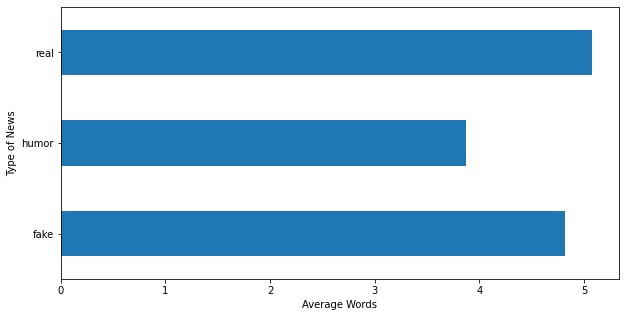

In [7]:
# Average Words in tweet text tokens vs Label

tr_df.groupby('label')['ntweetTextTokens'].mean().plot(kind='barh',figsize=(10,5))
plt.xlabel('Average Words')
plt.ylabel('Type of News')
plt.show()

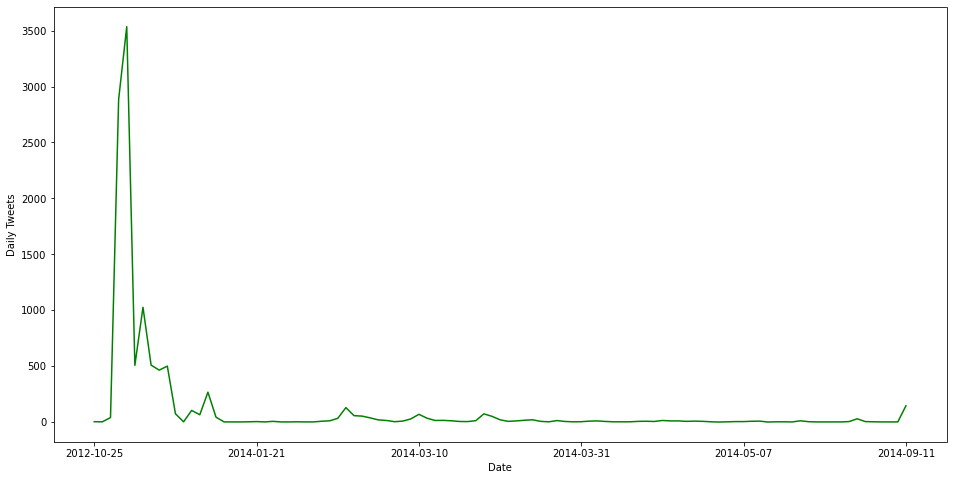

In [8]:
# Nuumber of tweets vs Date
tr_df.groupby('Date')['tweetTextTokens'].count().plot(kind='line', color='green', figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Daily Tweets')
plt.show()

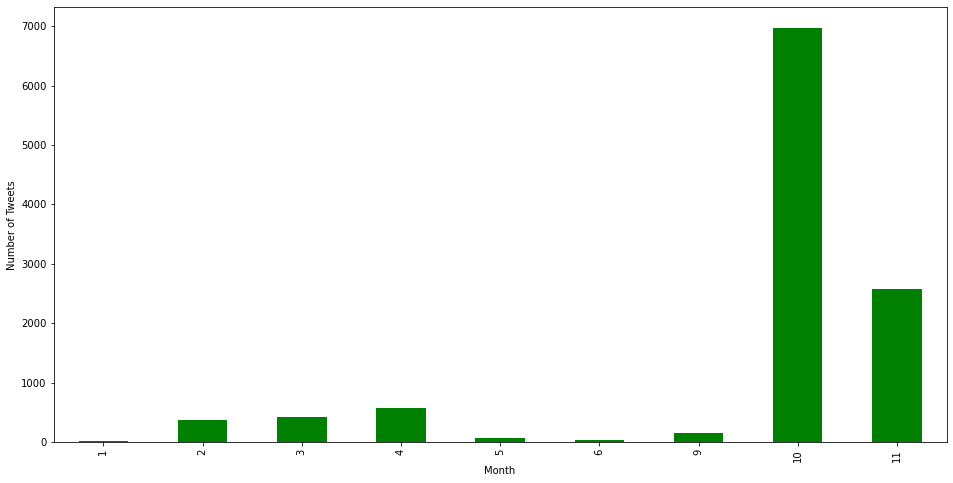

In [9]:
# Number of tweets vs Month
tr_df.groupby('Month')['tweetTextTokens'].count().plot(kind='bar', color='green', figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

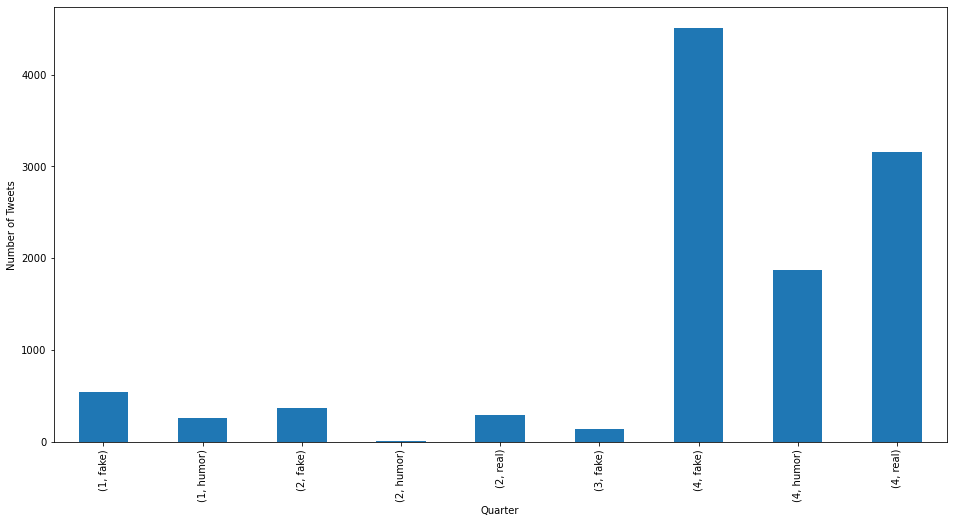

In [48]:
# Number of tweet in each quarter
tr_df.groupby(['Quarter','label'])['tweetTextTokens'].count().plot(kind='bar', figsize=(16,8))
plt.xlabel('Quarter')
plt.ylabel('Number of Tweets')
plt.show()

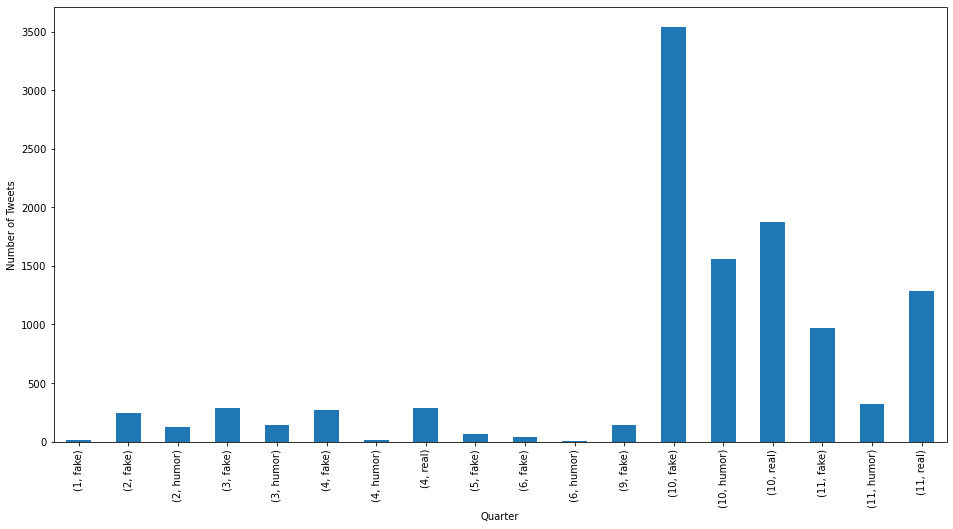

In [47]:
# Number of tweet in each quarter
tr_df.groupby(['Month','label'])['tweetTextTokens'].count().plot(kind='bar', figsize=(16,8))
plt.xlabel('Quarter')
plt.ylabel('Number of Tweets')
plt.show()

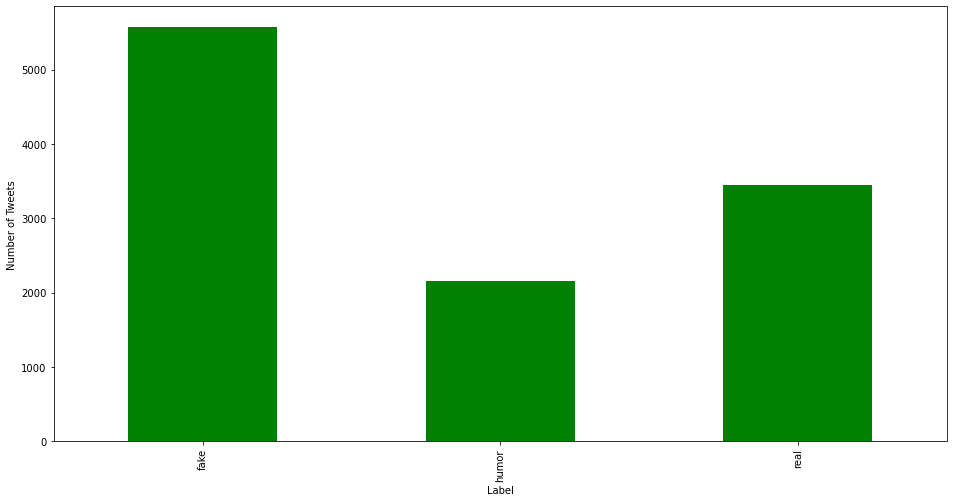

In [11]:
# Number of tweet in each label
tr_df.groupby('label')['tweetTextTokens'].count().plot(kind='bar', color='green', figsize=(16,8))
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.show()

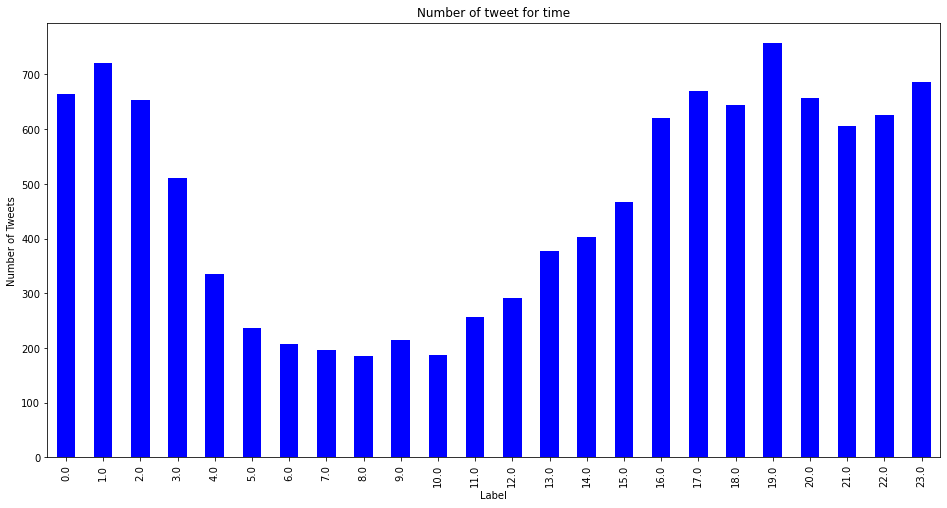

In [12]:
# Number of tweet for time
tr_df['timestamp'] = pd.to_datetime(tr_df['timestamp'])
tr_df.groupby([tr_df.timestamp.map(lambda t: t.hour)])['tweetTextTokens'].count().plot(kind='bar', 
                                                                                               color='blue', 
                                                                                               title= 'Number of tweet for time', 
                                                                                               figsize=(16,8))
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.show()



#### EDA:Generate Word Cloud

Preprocess Data for Word Cloud generation

In [13]:
#Separate all Classes
data_fake = tr_df[tr_df.label == "fake"]
data_humor = tr_df[tr_df.label == "humor"]
data_real = tr_df[tr_df.label == "real"]


#Filter NA items from the tokens
data_fake.dropna(axis=0,how='any',inplace=True)
data_humor.dropna(axis=0,how='any',inplace=True)
data_real.dropna(axis=0,how='any',inplace=True)

#Convert to list
fake_list = data_fake['tweetTextTokens'].tolist()
humor_list = data_humor['tweetTextTokens'].tolist()
real_list = data_real['tweetTextTokens'].tolist()


#Filtered List
#Convert List to String
filtered_fake = ("").join(fake_list)
filtered_humor = ("").join(humor_list) 
filtered_real = ("").join(real_list)

Email_mask_Fake = np.array(Image.open("Images/WordDistribution_Fake.png"))
Email_mask_Humor = np.array(Image.open("Images/WordDistribution_Humor.png"))
Email_mask_Real = np.array(Image.open("Images/WordDistribution_Real.png"))

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we l

##### Fake _ Word Tokens

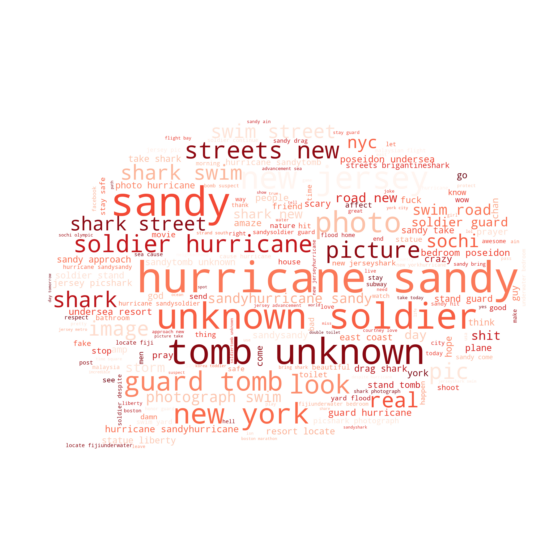

In [14]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size = 160, margin=0, 
                      mask = Email_mask_Fake, background_color = "white", 
                      colormap="Reds").generate(filtered_fake)
 
# Display the generated image

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)

plt.show()

##### Humor _ Word Tokens

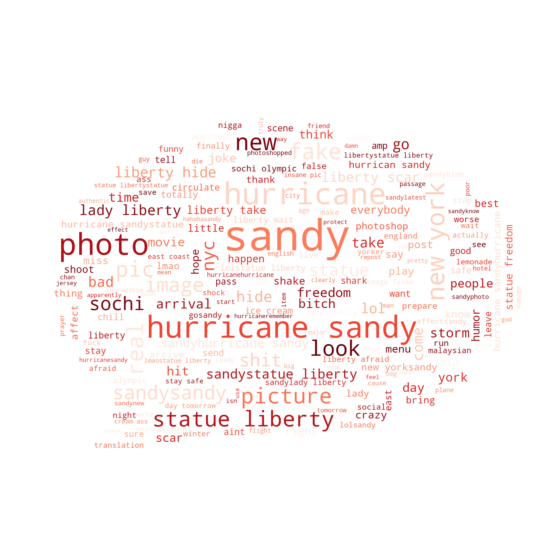

In [15]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size = 160, margin=0, 
                      mask = Email_mask_Humor, background_color = "white", 
                      colormap="Reds").generate(filtered_humor)
 
# Display the generated image

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)

plt.show()

##### Real _ Word Tokens

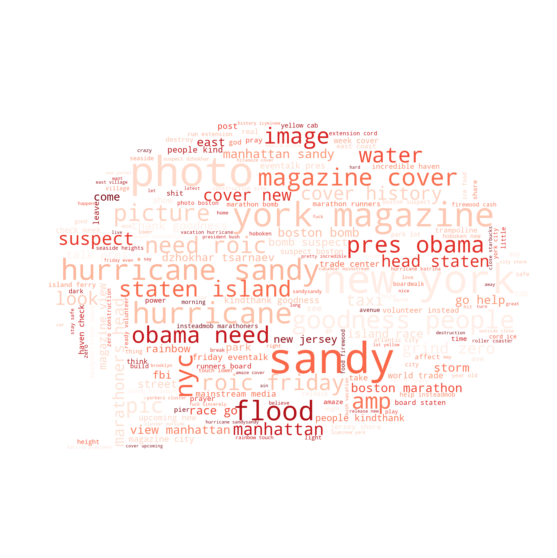

In [16]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size = 160, margin=0,
                      mask = Email_mask_Real, background_color = "white", 
                      colormap="Reds").generate(filtered_real)
 
# Display the generated image

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)

plt.show()

## Model Research

In [4]:
#Read CSV file-Dataset
tr_df = pd.read_csv('Finalized_Training.csv').drop(['Unnamed: 0','Unnamed: 0.1'], axis = 'columns')
#Drop NA columns for Vectorization
tr_df.dropna(axis=0,how='any',inplace=True)
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11175 entries, 0 to 11878
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweetId           11175 non-null  int64 
 1   timestamp         11175 non-null  object
 2   tweetText         11175 non-null  object
 3   userId            11175 non-null  int64 
 4   imageId(s)        11175 non-null  object
 5   username          11175 non-null  object
 6   label             11175 non-null  object
 7   DayOfMonth        11175 non-null  int64 
 8   DayOfYear         11175 non-null  int64 
 9   Month             11175 non-null  int64 
 10  Quarter           11175 non-null  int64 
 11  WeekOfYear        11175 non-null  int64 
 12  Year              11175 non-null  int64 
 13  tweetTextTokens   11175 non-null  object
 14  Date              11175 non-null  object
 15  Time              11175 non-null  object
 16  ntweetTextTokens  11175 non-null  int64 
dtypes: int64(9),

### Apply TF-IDF

This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. The term tf–idf stands for term frequency–inverse document frequency, it is a mathematical statistic that is planned to reflect how significant a word is to a record in a collection or corpus.

In [5]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(tr_df['tweetTextTokens'])
model_filename = "Model/TF-IDF Vectorizer.pkl"
pickle.dump(tfidf_vect, open(model_filename, 'wb'))
print('Shape TF-IDF:',X_tfidf.shape)
print('TF-IDF Feature Names:',tfidf_vect.get_feature_names()[:200])

Shape TF-IDF: (11175, 5893)
TF-IDF Feature Names: ['aaaayo', 'aah', 'aai', 'aandhi', 'aayi', 'abandon', 'abc', 'abcsandy', 'abgmwcus', 'able', 'abnieves', 'abo', 'abov', 'abozid', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'academy', 'accept', 'access', 'accommodation', 'accommodations', 'accomodations', 'accord', 'account', 'accuracy', 'accurate', 'accurately', 'accuse', 'acercandose', 'achanta', 'achieve', 'acid', 'acknowledge', 'acojonaica', 'act', 'action', 'activate', 'active', 'actively', 'activity', 'actual', 'actually', 'ada', 'add', 'addict', 'address', 'adkj', 'admire', 'admit', 'adryrodry', 'ads', 'advance', 'advancement', 'advantage', 'advent', 'adversity', 'advertise', 'advertisement', 'advice', 'ady', 'aerial', 'aey', 'affect', 'afford', 'afghanistan', 'afloat', 'afp', 'afraid', 'aft', 'aftermath', 'afternoon', 'agbani', 'age', 'aggravate', 'ago', 'agree', 'agreement', 'aha', 'ahaaa', 'ahah', 'ahaha', 'ahahah', 'ahahaha', 'ahahahaha', 'ahajjaja', 'ahead', 'ahh',

### Apply Count-Vectorizer

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. CountVectorizer creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix

In [6]:
count_vect = CountVectorizer()
X_count = count_vect.fit_transform(tr_df['tweetTextTokens'])
model_filename = "Model/Count Vectorizer.pkl"
pickle.dump(count_vect, open(model_filename, 'wb'))
print('Shape Count-Vect:',X_count.shape)
print('Count_Vect Feature Names:',count_vect.get_feature_names()[:100])

Shape Count-Vect: (11175, 5893)
Count_Vect Feature Names: ['aaaayo', 'aah', 'aai', 'aandhi', 'aayi', 'abandon', 'abc', 'abcsandy', 'abgmwcus', 'able', 'abnieves', 'abo', 'abov', 'abozid', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'academy', 'accept', 'access', 'accommodation', 'accommodations', 'accomodations', 'accord', 'account', 'accuracy', 'accurate', 'accurately', 'accuse', 'acercandose', 'achanta', 'achieve', 'acid', 'acknowledge', 'acojonaica', 'act', 'action', 'activate', 'active', 'actively', 'activity', 'actual', 'actually', 'ada', 'add', 'addict', 'address', 'adkj', 'admire', 'admit', 'adryrodry', 'ads', 'advance', 'advancement', 'advantage', 'advent', 'adversity', 'advertise', 'advertisement', 'advice', 'ady', 'aerial', 'aey', 'affect', 'afford', 'afghanistan', 'afloat', 'afp', 'afraid', 'aft', 'aftermath', 'afternoon', 'agbani', 'age', 'aggravate', 'ago', 'agree', 'agreement', 'aha', 'ahaaa', 'ahah', 'ahaha', 'ahahah', 'ahahaha', 'ahahahaha', 'ahajjaja', 'ahead'

### Random Forest Classifier

In [ ]:
# Using TF-IDF
rf_tfidf = RandomForestClassifier()
param_rf_tfidf = {'n_estimators': [ 400],
        'max_depth': [30]}

gs_tfidf = GridSearchCV(rf_tfidf, param_rf_tfidf, cv=cross_val, n_jobs=-1, verbose =1)
gs_tfidf_fit = gs_tfidf.fit(X_tfidf, tr_df['label'])
print('Result from Random Forest using TF-IDF')
rf_tf_idf = pd.DataFrame(gs_tfidf_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
print(rf_tf_idf)
rf_tf_idf.to_csv('Results/Random Forest(TF-IDF).csv')

# Using Count Vectorizer
rf_count = RandomForestClassifier()
param_rf_count = {'n_estimators': [400, 500,600,700,800,900],
        'max_depth': [30, 60, 90, None]}

gs_count = GridSearchCV(rf_count, param_rf_count, cv=cross_val, n_jobs=-1, verbose =1)
gs_count_fit = gs_count.fit(X_count, tr_df['label'])
print('Result from Random Forest using Count Vectorizer')
rf_cv = pd.DataFrame(gs_count_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]
print(rf_cv)
rf_cv.to_csv('Results/Random Forest(CV).csv')

### Gradient Boost Classifier

In [ ]:
# Using TF-IDF
gb_tfidf = GradientBoostingClassifier()
param_gbs_tfidf = {
    'n_estimators': [100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf_tfidf = GridSearchCV(gb_tfidf, param_gbs_tfidf, cv=cross_val, n_jobs=-1, verbose =1)
clf_tfidf_fit = clf_tfidf.fit(X_tfidf, tr_df['label'])
print('Result from Gradient Boost using TF-IDF')
gb_tf_idf = pd.DataFrame(clf_tfidf_fit.cv_results_).sort_values('mean_test_score', 
                                             ascending=False)[0:5]
print(gb_tf_idf)
gb_tf_idf.to_csv('Results/Gradient_Boost(TF-IDF).csv')

# Using Count Vectorizer
gb_count = GradientBoostingClassifier()
param_gbs_count = {
    'n_estimators': [100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf_count = GridSearchCV(gb_count, param_gbs_count, cv=cross_val, n_jobs=-1, verbose =1)
clf_count_fit = clf_count.fit(X_tfidf, tr_df['label'])
print('Result from Gradient Boost using Count Vectorizer')
gb_tf_cv = pd.DataFrame(clf_count_fit.cv_results_).sort_values('mean_test_score', 
                                             ascending=False)[0:5]
print(gb_tf_cv)
gb_tf_cv.to_csv('Results/Gradient_Boost(CV).csv')

### Multinomial Naive Bayes

In [ ]:
# Using TF-IDF
mnb_tfidf = MultinomialNB()
param_mnb_tfidf = {'alpha': [0.001, 0.01, 0.1, 1],
                'fit_prior': [True,False],
                'class_prior':[None]}

gs_mnb_tfidf = GridSearchCV(mnb_tfidf, param_mnb_tfidf, cv=cross_val, n_jobs=-1, verbose =1)
gs_mnb_tfidf_fit = gs_mnb_tfidf.fit(X_tfidf, tr_df['label'])
print('Result from Multinomial Naive Bayes using TF-IDF')
mnb_tf_idf = pd.DataFrame(gs_mnb_tfidf_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
print(mnb_tf_idf)
mnb_tf_idf.to_csv('Results/Multinomial NB(TF-IDF).csv')

# Using Count Vectorizer
mnb_count = MultinomialNB()
param_mnb_count = {'alpha': [0.001, 0.01, 0.1, 1],
                'fit_prior': [True,False],
                'class_prior':[None]}

gs_mnb_count = GridSearchCV(mnb_count, param_mnb_count, cv=cross_val, n_jobs=-1, verbose =1)
gs_mnb_count_fit = gs_mnb_count.fit(X_tfidf, tr_df['label'])
print('Result from Multinomial Naive Bayes using Count Vectorizer')
mnb_tf_count = pd.DataFrame(gs_mnb_count_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
print(mnb_tf_count)
mnb_tf_count.to_csv('Results/Multinomial NB(CV).csv')